$$
\newcommand{\L}{\mathcal{L}}
\newcommand{\p}{\partial}
\newcommand{\dd}{\mathrm{d}}
$$

# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

# `Семинар 01. Автоматическое дифференцирование`

### `Материалы основаны на лекции Кропотова Дмитрия Александровича, конспект составил Оганов Александр (@welmud)`

#### `Москва, Весенний семестр 2025`

`Материалы`

- [Лекция Дмитрия Александровича](https://m.youtube.com/watch?v=za2LgI8JFCw&pp=2AGDBJACAQ%3D%3D)

- [Дополнительный конспект прошлых лет](https://github.com/mmp-practicum-team/mmp_practicum_spring_2024/blob/c3205ef68e4e4fcd24fea6947f144dee7f6f7930/Seminars/Seminar%2002/tasks.pdf)

## `Автоматическое дифференцирование`

Основная тема занятия: "Как на компьютере вычислять производные функции?"

Мы предполагаем, что функция реализована на питоне и мы умеем ее вычислять, а целью является нахождение градиента, то есть производной функции по всем параметрам. Нахождение градиента необходимая задача при обучении нейронных сетей. На практике, при построении нейронной сети, мы реализуем только проход вперед (`forward pass`) - то как вход преобразуется через последовательность слоев, а подсчет градиента реализуется автоматически.

С точки зрения методов оптимизации существуют подходы безградиентной оптимизации (методы нулевого порядка), но обычно безградиентная оптимизация требует на порядки больше шагов для сходимости. Если ваша функция гладкая и есть возможность подсчета градиента, то крайне желательно этим воспользоваться.

Помимо `автоматического дифференцирования` есть другой подход к подсчету производной на компьютере с помощью разностного дифференцирования. 

Пусть есть функция $f(x)$ (можно вычислить в любой точке), тогда производную по направлению $d$ можно приблизить следующим образом:
$$
\begin{gather*}
    \nabla f(x)^T d = \frac{f(x + \varepsilon d) - f(x)}{\varepsilon},
\end{gather*}
$$
где $\varepsilon$ близкое к нулю число. Следовательно, если есть процедура вычисления функции $f$, то можно высчитать производную для каждого параметра нейронной сети.

**Вопрос:** Почему таким способом не действуют для вычисления градиента при обучении нейронной сети?

Данный способ хорошо подходит для проверки корректности подсчета градиента, но не пригоден для использования во время обучения. 

Вместо разностного подхода используют методы `автоматического дифференцирования`, то есть вычисление производной по графу вычислений. 

### `Пример графа вычислений`

Рассмотрим следующую функцию:

$$
\begin{gather*}
    f(x_1, x_2, x_3) = \frac{x_1 x_2 \sin(x_3) + exp(x_1 x_2)}{x_3}.
\end{gather*}
$$

Первый шаг: по формуле построить граф вычислений, пример графа вычислений, который реализует предложенную функцию $f$ представлен ниже


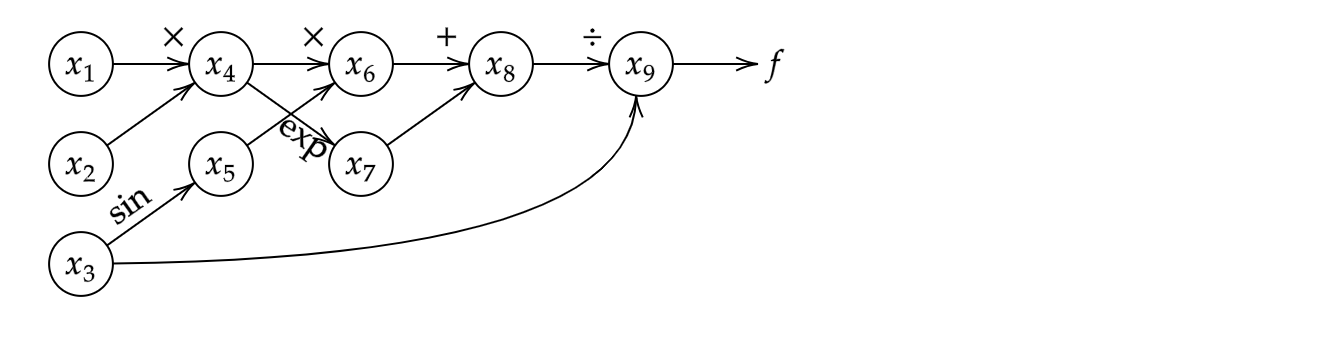

**Вопрос:** Однозначно ли задается граф вычислений по формуле, которой записана функция?

Так как наша главная задача вычислить производную на компьютере, то есть мы описываем вычисление функции на Python, а значит по нашему коду и строиться граф вычислений.

### `Вычисление производных по графу`

Наша основная цель вычислить градиент функции, то есть посчитать производные $f$ по независимым переменным $x_1, x_2, x_3$ с помощью автоматического дифференцирования.


В общем случае выделяют 3 режима работы:

- вычисления производной проходом вперед (`forward mode`)
- вычисления производной проходом назад (`backward mode`)
- смешанный


### `Проход вперед для вычисления производной`


Следуя названию метода мы будем вычислять производную слева направо, соответственно мы будем пересчитывать:

$$
\begin{gather*}
    \frac{\p x_i}{\p x_j}, \quad i = 1, \ldots, 9, \quad j = 1, 2, 3.
\end{gather*}
$$

Соответственно проинициализируем  значения на первом слое:


$$
\begin{gather*}
    \frac{\p x_1}{\p x_1} = 1, \frac{\p x_2}{\p x_1} = 0, \frac{\p x_3}{\p x_1} = 0.
\end{gather*}
$$

Дальше мы делаем шаг вперед, например, вычисляем $x_4$ и сразу считаем производные, используя производные с прошлого слоя.

$$
\begin{align*}
    &x_4 = x_1 x_2,\\
    &\frac{\p x_4} {\p x_1} =  \frac{\p x_1} {\p x_1} x_2 + x_1 \frac{\p x_2} {\p x_1}.
\end{align*}
$$

Для $x_5$ мы получим следующее:

$$
\begin{align*}
    &x_5 = \sin(x_3),\\
    &\frac{\p x_5} {\p x_1} =  \cos(x_3) \frac{\p x_3} {\p x_1}.
\end{align*}
$$


В общем случае для графа:

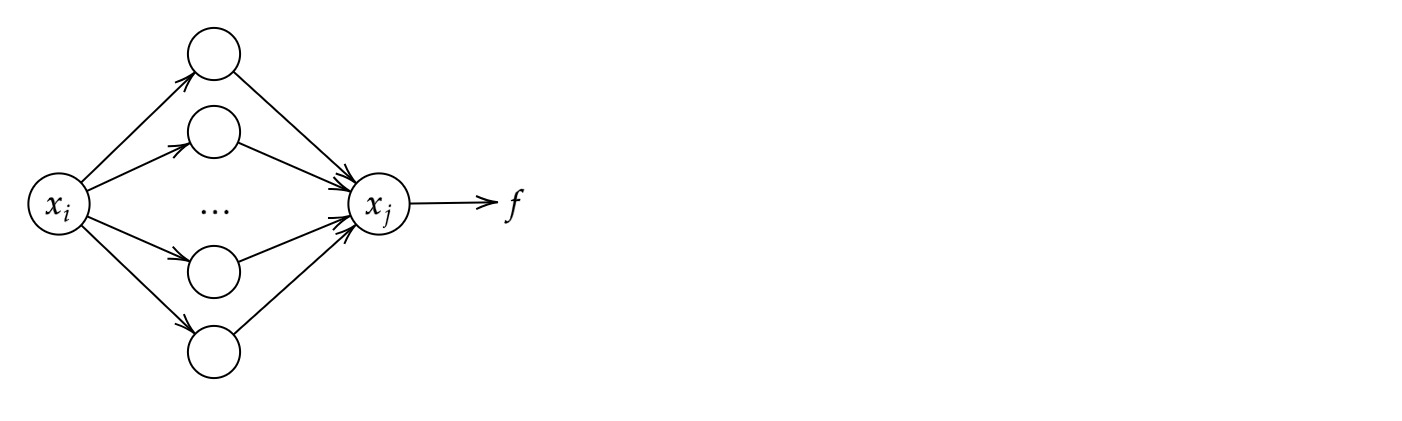

Мы получим:

$$
\begin{gather*}
    \frac{\p x_j}{\p x_i} = \sum_{k : (k, j) \in \Sigma}  \frac{\p x_j}{\p x_k} \frac{\p x_k}{\p x_i},
\end{gather*}
$$
где запись $(k, j) \in \Sigma$ означает, что есть ребро из $k$ в $j$. $ \frac{\p x_k}{\p x_i}$ мы знаем с прошлой итерации, а $\frac{\p x_j}{\p x_k}$ сможем вычислить на ходу. Заметим, что нам требуется хранить производные только с прошлого слоя, а при переходе на новый слой мы можем забыть старый.

**Вопрос:** Какие недостатки вы видите при вычислении производной в режиме прохода вперед (`forward mode`)? 

В области обычно считают, что вычисление производной имеет порядок сложности сравнимый с вычислением функции (с точки зрения формул). Например, посчитать $\sin$ также трудно, как и посчитать $\cos$.

### `Проход вперед для вычисления производной`

Как следует из названия мы будем вычислять производную справа налево, соответственно нас будут интересовать:

$$
\begin{gather*}
    \frac{\p f}{\p x_j}, \quad j = 1, \ldots, 9.
\end{gather*}
$$

Соответственно проинициализируем значения:


$$
\begin{gather*}
    \frac{\p f}{\p x_9} = 1.
\end{gather*}
$$

Далее идем налево:


$$
\begin{gather*}
    \frac{\p f}{\p x_8} = \frac{\p f}{\p x_9} \frac{\p x_9}{\p x_8} = \frac{\p f}{\p x_9} \frac{1}{x_3}.
\end{gather*}
$$

Рассмотрим произвольный шаг, например, найдем $\frac{\p f}{\p x_4}$, следовательно, мы уже нашли $\frac{\p f}{\p x_6}$ и $\frac{\p f}{\p x_7}$, воспользуемся этим:

$$
\begin{gather*}
    \frac{\p f}{\p x_4} = \frac{\p f}{\p x_6} \frac{\p x_6}{\p x_4} + \frac{\p f}{\p x_7} \frac{\p x_7}{\p x_4}.
\end{gather*}
$$

В общем случае для графа:

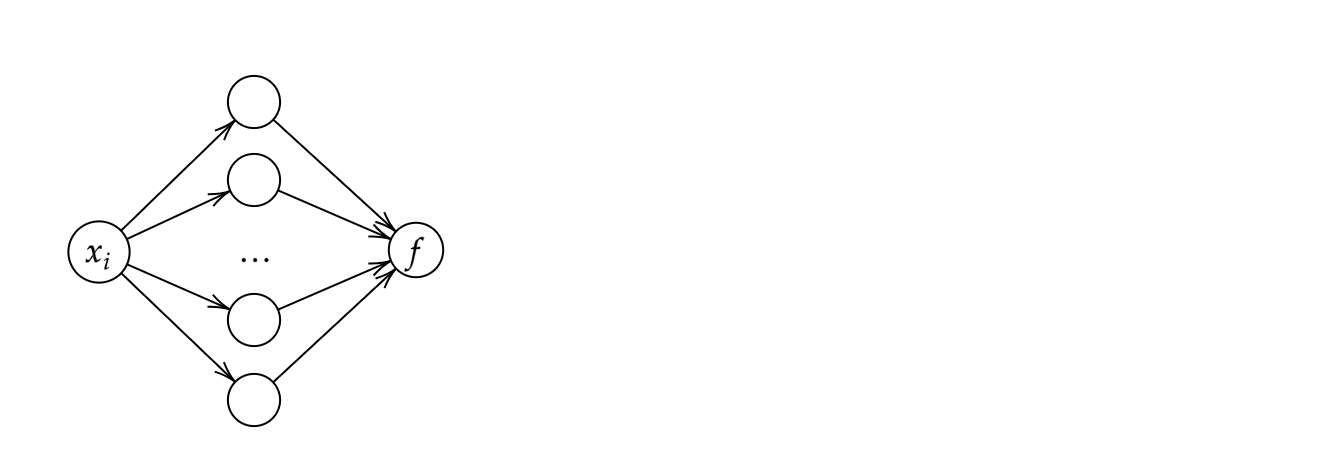

Мы получим:

$$
\begin{gather*}
    \frac{\p f}{\p x_j} = \sum_{k : (j, k) \in \Sigma}  \frac{\p f}{\p x_k} \frac{\p x_k}{\p x_j}.
\end{gather*}
$$


Заметим, что после работы алгоритма мы получаем полный вектор градиента, следовательно, мы рассчитываем все необходимое за один проход. 

**Вопрос:** Крайне редко алгоритм, который смотрит на задачу с другой стороны может работать эффективней без какой-либо платы. За счет чего была достигнута эффективность?

### `Смешанный режим вычисления производной`

Рассмотрим следующий граф, где $y$ скалярная переменная:

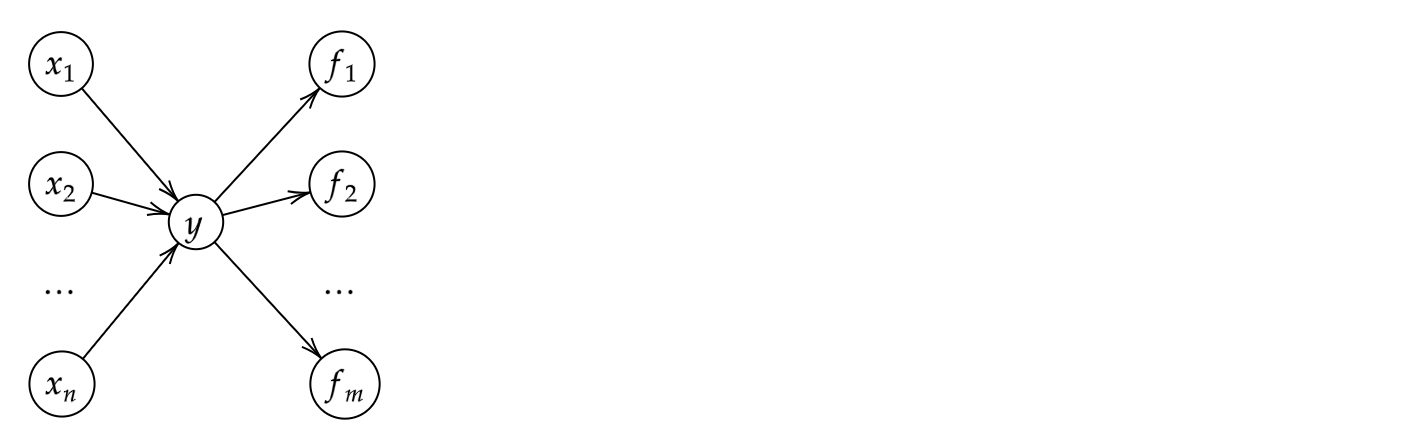

Нас интересует матрица якобиана, то есть $\frac{\p f_j}{\p x_i}$.

**Вопрос:** в каком режиме получится максимально эффективно вычислить якобиан?

Мы можем воспользоваться структурой графа и вычислить левую часть графа проходом назад, а правую проходом вперед. Мы получим, что $\frac{\p f_j}{\p x_i} = \frac{\p f_j}{\p y} \frac{\p y}{\p x_i}$, то есть суммарно прошли по графу вычислений один раз. Такой подход основан на анализе графа вычислений, есть отдельные конференции посвященные вычислению и поиску специальных подграфов для их эффективного вычисления. В целом задача прохода по графу вычислений очень схожа на работу компилятора и применяемых в нем оптимизаций. Задача перевода кода и поиск шаблонов для эффективного перевода в машинный код схожа на задачу `автоматического дифференцирования`.

На практике мы крайне редко столкнемся с использованием прямого и смешанного режима, так как в основных фреймворках все написано для прохода назад. Например, [PyTorch только недавно научился поддерживать `forward mode`](https://pytorch.org/tutorials/intermediate/forward_ad_usage.html).

## `Матрично-векторное дифференцирование`

Выше мы разобрали примеры, в которых участвовали скалярные функции, при этом на практике мы в основном работаем с матрицами. Теперь мы разберем более интересные примеры.

### `Градиенты через решение СЛАУ`

Допустим у нас есть СЛАУ $Ax = b$, где $A \in \mathbb{R}^{n \times n}, \det(A) \neq 0$, дальше для подсчета лосса модели мы как-то используем решение $x$. Цель найти градиент функции потерь по матрице $A$ и по вектору $b$, то есть найти $\nabla_A f$ и $\nabla_b f$.

Для начала составим граф вычислений:

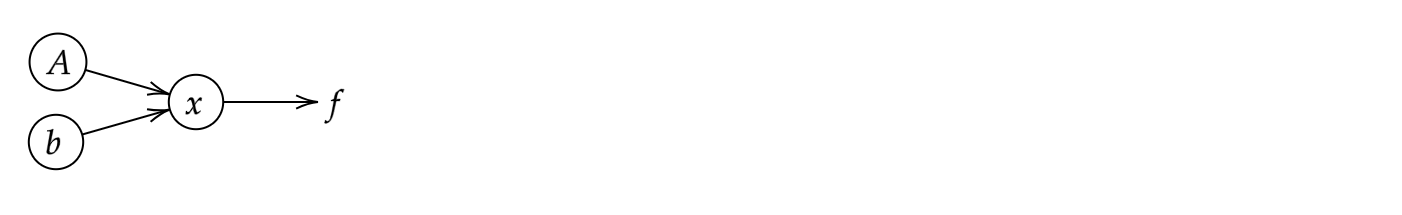

Мы будем пользоваться свойством инвариантности формы первого дифференциала, то есть верно:

$$
\begin{gather*}
\dd f = \nabla_x f^T \dd x,
\end{gather*}
$$
если мы рассматриваем функцию $f$ в параметризации $x$, и верно:

$$
\begin{gather*}
\dd f = \nabla_b f^T \dd b + \bigl(\nabla_A f, \dd A \bigr),
\end{gather*}
$$

если мы смотрим на $f$ в параметризации $A, b$ (так как $x$ зависит от $A, b$).

Для нахождения градиентов мы распишем $\dd x$ через $\dd A$ и $\dd b$ сгруппируем слагаемые, соответсвующее коэффициенты и будут необходимыми градиентами.

**Вопрос:** Как найти $\dd x$?

У нас есть только одно уравнение, дающее связь между $A, b$ и $x$, продифференцируем его:

$$
\begin{align*}
& Ax = b,\\
& \dd A x + A \dd x = \dd b,\\
& \dd x = A^{-1} (\dd b - \dd A x).
\end{align*}
$$


Подставим $dx$ и получим:

$$
\begin{align*}
&\dd f = \nabla_x f^T \dd x =  \nabla_x f^T A^{-1} (\dd b - \dd A x) = \\
&=  \nabla_x f^T A^{-1} \dd b -  \nabla_x f^T A^{-1} \dd A x = \nabla_b f^T \dd b + \bigl(\nabla_A f, \dd A \bigr).
\end{align*}
$$

Откуда находим:

$$
\begin{gather*}
\nabla_b f = A^{-T} \nabla_x f.
\end{gather*}
$$

Вспомним, что $\dd f$ число, а значит $\nabla_x f^T A^{-1} \dd A x$ тоже должно быть числом, следовательно:

$$
\begin{gather*}
\nabla_x f^T A^{-1} \dd A x = tr(\nabla_x f^T A^{-1} \dd A x) = tr(x \nabla_x f^T A^{-1} \dd A) =  \bigl(A^{-T}\nabla_x f x^T, \dd A \bigr).
\end{gather*}
$$

Откуда получим:

$$
\begin{gather*}
\nabla_A f = - A^{-T}\nabla_x f x^T = - \nabla_b f x^T.
\end{gather*}
$$

Для нахождения градиента по $A$, надо знать градиент по $b$, который является решением СЛАУ $A^T \nabla_b f = \nabla_x f$. Мы получили, что вычисление производной схоже порядком сложности на вычисление функции (в обоих случаях надо решать СЛАУ).

Так как мы не привязывали алгоритм к конкретному методу получения $x$ из $A$ и $b$, мы можем обсудить как на практике можно решать СЛАУ.

**Вопрос:** Какие методы решения СЛАУ вы знаете?

Воспользуемся $LU$-разложением, тогда получим:

$$
\begin{align*}
&A = LU,\\
&Ax = b \Rightarrow LU x = b,\\
&Ly = b, Ux = y,\\
&y = L^{-1} b, x = U^{-1} y,\\
&x = U^{-1} L^{-1} b.
\end{align*}
$$

Обратить треугольную матрицу можно, например, методом Гаусса за $O(n^2)$, то есть для подсчета производной мы можем считать эффективно, не зная, как получалось $x$ (возможно и за $O(n^3)).


### `Логистическая регрессия`

Рассмотрим логистическую регрессию, пусть $x \in \mathbb{R}^n$, $y \in \{ 1, 2, \ldots, k\}$, $z = Wx + b$, где  $W \in \mathbb{R}^{k \times d}$. Для вычисления функции потерь нам нужно знать вероятности каждого класса, поэтому обозначим их за $p$, где $p = \frac{\exp(z)}{\exp(z)^T \mathbb{1}}$ ($exp(z)$ поэлементная функция, $\mathbb{1}$ вектор из всех единиц).


**Вопрос:** Как выглядит функция потерь для многоклассовой классификации?

Функцию потерь можно записать как $L(p, y) = - \log p^T \mathbb{1}_y$. Теперь когда мы все определили, запишем граф вычислений:

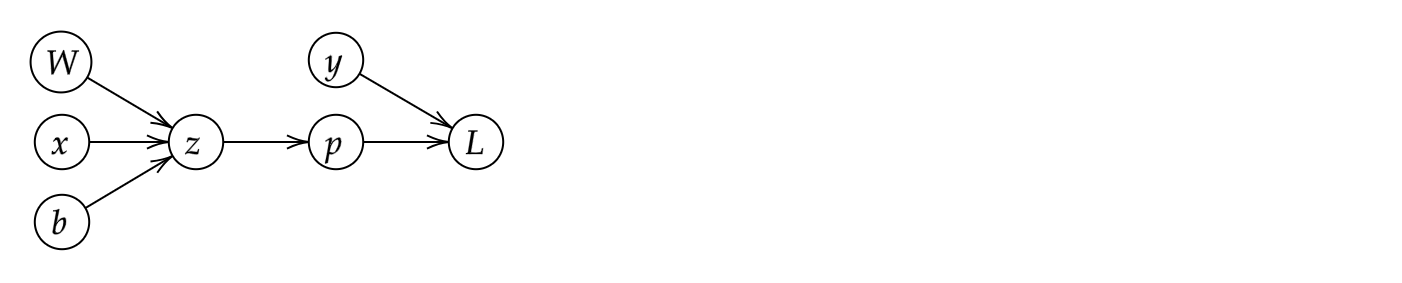

Для $\dd L$ выполнено следующее:

$$
\begin{gather*}
\dd L = \nabla_p L^T \dd p = - (\frac{1}{p^T \mathbb{1}_y}) \mathbb{1}_y \dd p.
\end{gather*}
$$

Пользуясь инвариантностью первого дифференциала, мы знаем, что:

$$
\begin{gather*}
\dd L = \nabla_p L^T \dd p = \nabla_z L^T \dd z.
\end{gather*}
$$

То есть наша задача найти чему равно $\dd p$, для этого продифференцируем $p$ по определению:

$$
\begin{align*}
&\dd p = \frac{diag(\exp(z)) \dd z \exp(z)^T \mathbb{1} - \exp(z) \mathbb{1}^T diag(\exp(z))\dd z }{(\exp(z)^T \mathbb{1})^2} =\\
&=\frac{1}{\exp(z)^T \mathbb{1}} diag(\exp(z))\dd z - \frac{1}{(\exp(z)^T \mathbb{1})^2} \exp(z) \mathbb{1}^T diag(\exp(z))\dd z.
\end{align*}
$$


Подставим $\dd p$ в выражение $\dd L$ для нахождение $\nabla_z L$:

$$
\begin{gather*}
\dd L = \nabla_z L^T \dd z = \bigl[\nabla_p L^T \frac{1}{\exp(z)^T \mathbb{1}} diag(\exp(z)) - \nabla_p L^T \frac{1}{(\exp(z)^T \mathbb{1})^2} \exp(z) \mathbb{1}^T diag(\exp(z))\bigr]\dd z.
\end{gather*}
$$

Тогда получим:
$$
\begin{gather*}
\nabla_z L =  \frac{1}{\exp(z)^T \mathbb{1}} diag(\exp(z))\nabla_p L - \frac{\nabla_p L^T \exp(z)}{(\exp(z)^T \mathbb{1})^2}diag(\exp(z)) \mathbb{1}.
\end{gather*}
$$


Для нахождения градиентов по параметрам $z$, заметим:

$$
\begin{align*}
&z = Wx + b,\\
&\dd z = \dd W x + W \dd x + \dd b,\\
&\nabla_z L^T dz = \nabla_z L^T \dd W x + \nabla_z L^T W \dd x + \nabla_z L^T \dd b.
\end{align*}
$$

Откуда не трудно найти градиенты.

$$
\begin{align*}
&\nabla_b L = \nabla_z L,\\
&\nabla_x L = W^T\nabla_z L,\\
&\nabla_W L = \nabla_z L x^T.
\end{align*}
$$


### `Общий вид`

Выше мы рассмотрели конкретные примеры, теперь изучим нейросеть как некую последовательность слоев в общем виде. Любую нейросеть можно представить в виде следующего графа.

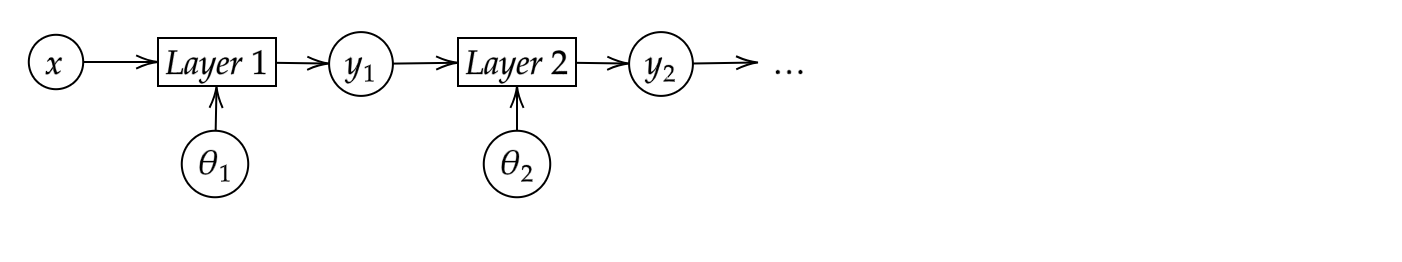

Для автоматического дифференцирования необходимо реализовать две функции: `forward` и `backward`.
 
 
Функция `forward` задается как $y_{i+1} = forward(y_i, \theta_{i+1})$


Функция `backward` необходима для прохода назад. $backward(\nabla_{y_{i+1}} L, y_i, y_{i+1}, \theta_{i+1})$ вычисляет $\nabla_{y_{i}} L, \nabla_{\theta_{i+1}} L$


В большинстве случаев `PyTorch` сам реализует функцию `backward` по уже заданной `forward`. Однако бывают примеры, когда приходится самому явно реализовывать `backward`, например, при работе с комплексными эмбеддингами. Часто комплексные числа возникают при обработке сигналов, так как многие алгоритмы используют преобразование Фурье.

Другим примером служит более эффективная реализация `backward`. Иногда, вы знаете что определенные слои идут последовательно и разумней их объединить (использовать  `fuse`) для [более эффективного вычисления](https://pytorch.org/tutorials/recipes/fuse.html). Подробнее с этими примерами мы познакомимся позже

### `Градиенты через итерационный процесс`

Первый наш пример был о том, как прогнать градиент через решение СЛАУ. Мы получили формулы, которые **никак не зависят** от способа получения решения. Мы бы могли залезть внутрь алгоритма, например, рассмотреть конкретный способ нахождения решения СЛАУ. Тогда можно было бы итерации численного метода рассмотреть как слои нейронной сети, как куски графа вычислений и гнать производную через граф вычислений стандартными методами. Такой подход требует дополнительной памяти (надо хранить промежуточные значения).

Мы рассмотрим частный случай, когда можно посмотреть на алгоритм, с которым работаем и воспользоваться его структурой, мы по сути будем инвертировать его итерации.


Рассмотрим пример: сумма членов геометрической прогрессии

Пусть $q \in (0, 1)$, $s_n = 1 + q + \ldots + q^n$ и $s_n$ как-то используется для вычисления функции потерь $f(s_n)$. Заметим, что $s_n = 1 + q * s_{n-1}$.

Простой способ: записать аналитическую формулу и прогнать через нее градиенты. В этом случае мы не учитываем ошибки округления и численную стабильность, тем самым получаем смещенное значения градиента, что делает процедуру не корректной.


Второй способ: прогнать градиенты через итерации алгоритма. Для этого запишем граф вычислений.

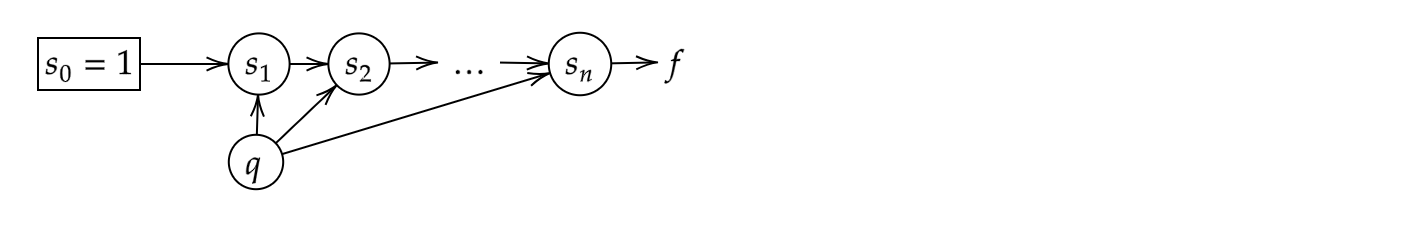

Пусть мы знаем $\frac{\p f}{\p s_n}$, тогда мы можем записать:
$$
\begin{align*}
&\dd f = \frac{\p f}{\p s_n} \dd s_n = \\
&= \frac{\p f}{\p s_n}(\dd q s_{n-1} + q \dd s_{n-1}).
\end{align*}
$$

Откуда получаем:

$$
\begin{align*}
&\frac{\p f}{\p s_{n-1}} = \frac{\p f}{\p s_n} q,\\
&\frac{\p f}{\p q} = \frac{\p f}{\p s_n} s_{n-1}.
\end{align*}
$$

То есть формально, чтобы узнать $\frac{\p f}{\p q}$ необходимо вычислить $s_{n-1}$ и так рекурсивно пройти по всему графу. С другой стороны мы знаем, что  $s_{n-1} = \frac{s_n - 1}{q}$ (обратная итерация) и тогда:


$$
\begin{align*}
&\frac{\p f}{\p q} = \frac{\p f}{\p s_n} \frac{s_n - 1}{q}.
\end{align*}
$$

Такой способ не всегда работает, так как у нас была явная формула и мы смогли легко инвертировать. Например, если слой нейронной сети это метод оптимизации, то для `SGD` не существует метода инвертации. Примерами, когда мы можем инвертировать, являются `SGD` с моментумом и `Adam`. Подход с инвертацией позволяет значительно ускорить обучение.

### `Градиент через сингуряные числа`

Рассмотрим матрицу $W \in \mathbb{R}^{n \times m}$ и ее сингулярное разножение (SVD) $W = U \Sigma V^T$, где $U^T U = I$ и $V V^T = I$, матрица $\Sigma$ является диагональной, где на диагонали стоят сингулярные числа $\{ \sigma_1, \ldots, \sigma_{\min(n, m)}\}$

**Вопрос:** Зачем сингулярные числа могут быть полезны в нейронных сетях?

Часто, когда говорят про SVD, рассматривают ядерную норму матрицы, которую можно записать как $\| W \|_{*} = trace(\Sigma) = \sum \sigma_i$

Если к нашему лоссу мы добавим ядерную норму, то получится регуляризация, которая поощряет матрицы наименьшего ранга.
$$
\begin{gather*}
Loss(W, y, X) + \lambda \| W \|_{*} \to \min_{W}
\end{gather*}
$$

Построим граф вычислений.

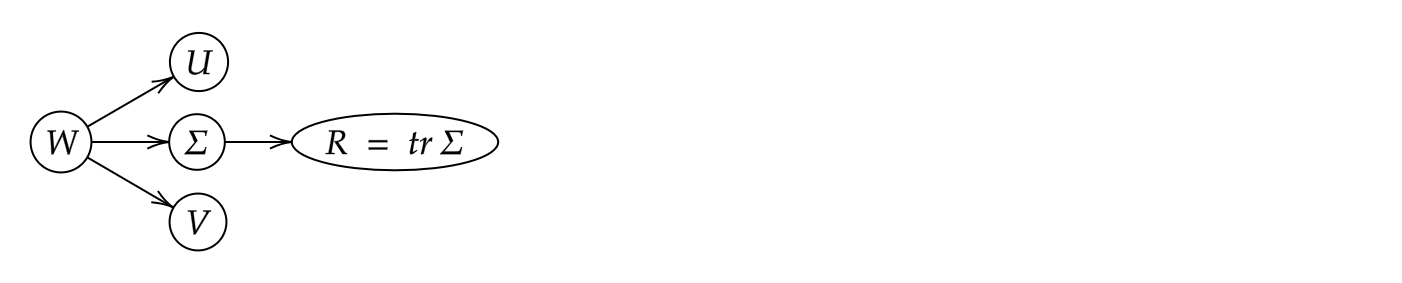

Наша цель найти $\nabla_{W} R$ (мы хотим обновить матрицу), а значит по аналогии с первым примером нам потребуется найти $\dd \Sigma$.

$$
\begin{align*}
&W = U \Sigma V^T,\\
&\dd W = \dd U \Sigma V^T + U \dd \Sigma V^T + U \Sigma \dd V^T,\\
&U^T\dd W V = U^T \dd U \Sigma + \dd \Sigma +\Sigma \dd V^T V.
\end{align*}
$$

Рассмотрим $U^T \dd U$, есть ощущение, что это должна быть какая-то особенная матрица, так как у нас есть ограничения на вид $U$.

$$
\begin{align*}
&U^T U = I,\\
&\dd U^T U + U^T \dd U = 0.
\end{align*}
$$

Если мы обозначим за $C = \dd U^T U$, то выше мы получили $C + C^T = 0$, следовательно, $C$ кососимметричная  матрица. Этот факт означает, что на диагонали у матрицы $C$ стоят нули. Откуда получаем, что $(C \Sigma)_ii = 0$, так как $\Sigma$ диагональная матрица. Кроме того мы знаем, что  $\dd \Sigma$ тоже диагональная, а значит:

$$
\begin{align*}
&\dd \Sigma = diag(U^T\dd W V - U^T \dd U \Sigma - \Sigma \dd V^T V) =  diag(U^T\dd W V).
\end{align*}
$$

Так как $\dd R = \bigl( \nabla_{\Sigma} R, \dd \Sigma \bigr) = tr( \nabla_{\Sigma} R^T \dd \Sigma) = tr( \nabla_{\Sigma} R^T  diag(U^T\dd W V)) = tr( \nabla_{\Sigma} R^T  U^T\dd W V)$, мы получим $\nabla_{W} R = U \nabla_{\Sigma} R V^T$. 


Тем самым мы можем регуляризировать сверточные слои (поощрять матрицы с меньшим рангом). Ядерную норму используют на практике, например, в [NVidia](https://github.com/NVlabs/LSGM/blob/5eae2f385c014f2250c3130152b6be711f6a3a5a/util/sr_utils.py#L22).